In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [4]:
transform = transforms.Compose(
    [
        # transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomVerticalFlip(p=0.05),
        transforms.RandomHorizontalFlip(p=0.05),
        transforms.RandomGrayscale(p=0.1),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)  # 3 valores para as 3 dims, e dois elementos na tupla um para a media e o outro para o std

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


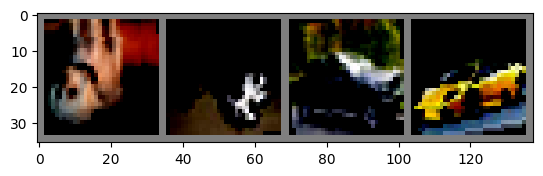

dog   dog   car   car  


In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
# Construindo o modelo
class CIFFARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 32, 3)
        self.conv3 = nn.Conv2d(32, 16, 2)
        self.fc1 = nn.Linear(16 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

ciffar_model = CIFFARModel().to(device)

In [9]:
ex_input = torch.rand([1, 3, 32, 32]).to(device)
with torch.no_grad():
    x = ciffar_model(ex_input)
    print(x)

tensor([[-0.0495, -0.0900, -0.0113, -0.0486, -0.1060, -0.1215, -0.0727, -0.0922,
          0.0046, -0.1083]], device='cuda:0')


In [10]:
# usando CrossEntropyLoss não é preciso usar uma sigmoid ao final
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ciffar_model.parameters(), lr=0.001, momentum=0.9)

In [15]:
EPOCHS = 20

progress = tqdm(trainloader, total=len(trainloader))
accum_loss = None

for epoch in range(EPOCHS):
    update_count = 0
    for inputs, labels in progress:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = ciffar_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if accum_loss is not None:
            accum_loss = 0.99 * accum_loss + 0.01 * loss.detach().cpu().item()
        else:
            accum_loss = loss.detach().cpu().item()    
        
        update_count += 1
        progress.set_description(
            f"Epoca: {epoch}\tUpdate: {update_count}\tLoss: {loss.detach().cpu().item():.4f}\tAccum_loss: {accum_loss:.4f}"
        )
    print(epoch)

Epoca: 0	Update: 12500	Loss: 1.0885	Accum_loss: 1.1286: 100%|███████████████████| 12500/12500 [01:28<00:00, 141.44it/s]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [16]:
# salvando o modelo
PATH = 'models/cifar_net.pth'
torch.save(ciffar_model.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


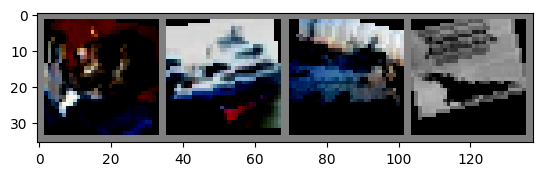

GroundTruth:  cat   ship  ship  plane


In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [18]:
# carregando o modelo
net = CIFFARModel()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
net = net.to(device)

In [20]:
outputs = net(images.to(device))

In [21]:
_, predicted = torch.max(outputs, 1)

In [22]:
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.1 %
Accuracy for class: car   is 85.3 %
Accuracy for class: bird  is 55.5 %
Accuracy for class: cat   is 43.5 %
Accuracy for class: deer  is 54.2 %
Accuracy for class: dog   is 49.8 %
Accuracy for class: frog  is 72.0 %
Accuracy for class: horse is 64.9 %
Accuracy for class: ship  is 78.8 %
Accuracy for class: truck is 54.1 %


- [ ] Faça uma matriz de confusão veja em qual classe ele está se confundindo
- [ ] Faça Data Augmentation para ver se consegue melhorar o desempenho do modelo